In [1]:
import matplotlib.pyplot as plt
import numpy as np
import json
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Input, concatenate
from tensorflow.keras.models import Model
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt


2025-04-03 10:12:24.207670: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-03 10:12:24.298704: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-03 10:12:24.302287: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-04-03 10:12:24.302299: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart d

(-0.5, 1023.5, 1023.5, -0.5)

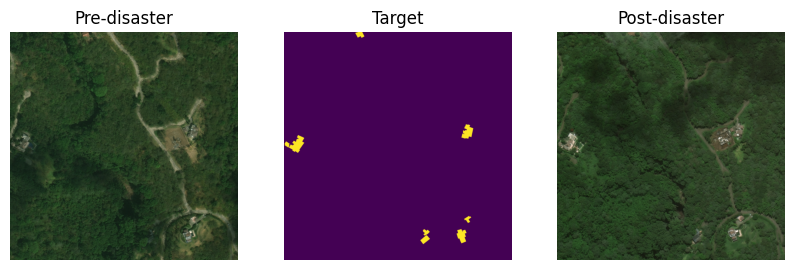

In [2]:
# Just visualize some data
im2 = plt.imread('dataset/train/targets/guatemala-volcano_00000007_post_disaster_target.png')
im3 = plt.imread('dataset/train/images/guatemala-volcano_00000007_post_disaster.png')
im = plt.imread('dataset/train/images/guatemala-volcano_00000007_pre_disaster.png')
plt.figure(figsize=(10, 10))
plt.subplot(131)
plt.title('Pre-disaster')
plt.imshow(im)
plt.axis('off')
plt.subplot(132)
plt.title('Target')
plt.imshow(im2)
plt.axis('off')
plt.subplot(133)
plt.title('Post-disaster')
plt.imshow(im3)
plt.axis('off')

In [3]:
# 1️⃣ Load and Preprocess Data
IMG_SIZE = (256, 256)
TRAIN_DATASET_PATH = "dataset/train/"
TRAIN_IMAGES_PATH = os.path.join(TRAIN_DATASET_PATH, "images")
TRAIN_MASKS_PATH = os.path.join(TRAIN_DATASET_PATH, "targets")  # Segmentation masks
TRAIN_LABELS_PATH = os.path.join(TRAIN_DATASET_PATH, "labels")  # JSON labels

TEST_DATASET_PATH = "dataset/test/"
TEST_IMAGES_PATH = os.path.join(TEST_DATASET_PATH, "images")
TEST_MASKS_PATH = os.path.join(TEST_DATASET_PATH, "targets")  # Segmentation masks
TEST_LABELS_PATH = os.path.join(TEST_DATASET_PATH, "labels")  # JSON labels

# Constants
IMG_SIZE = (256, 256)
BATCH_SIZE = 16  # Adjust based on your RAM
BUFFER_SIZE = 150  # Adjust based on dataset size



In [6]:
# Function to load and preprocess images and masks
def load_image(image_path):
    """Load and preprocess images and masks."""
    img = cv2.imread(image_path)
    # if img is None:
    #     print(f"❌ Failed to load image: {image_path}")
    #     return None
    # print(f"✅ Loaded image {image_path}, Shape: {img.shape}, Dtype: {img.dtype}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMG_SIZE) / 255.0  # Normalize
    return img

def load_mask(mask_path,num_classes=5):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    # if mask is None:
    #     print(f"❌ Failed to load mask: {mask_path}")
    #     return None
    # print(f"✅ Loaded mask {mask_path}, Shape: {mask.shape}, Dtype: {mask.dtype}")
    if mask is None:
        return None
    mask = cv2.resize(mask, IMG_SIZE)
    mask = tf.keras.utils.to_categorical(mask, num_classes=num_classes)
    return mask


In [7]:
# Function to load dataset using tf.data
def dataset_generator(image_filenames, images_path, masks_path):
    """Generator function to yield images and masks."""
    for filename in image_filenames:
        pre_path = os.path.join(images_path, filename)
        post_path = os.path.join(images_path, filename.replace("_pre_disaster", "_post_disaster"))
        mask_path = os.path.join(masks_path, filename.replace("_pre_disaster.png", "_post_disaster_target.png"))

        pre_img = load_image(pre_path)
        post_img = load_image(post_path)
        mask_img = load_mask(mask_path) # Now returns (256, 256, 5)
        

        if pre_img is not None and post_img is not None and mask_img is not None:
            stacked_image = np.concatenate([pre_img, post_img], axis=-1)  # Shape: (256, 256, 6)
            yield stacked_image, mask_img

# Create TensorFlow dataset
def get_tf_dataset(image_filenames, images_path, masks_path, batch_size):
    dataset = tf.data.Dataset.from_generator(
        lambda: dataset_generator(image_filenames, images_path, masks_path),
        output_signature=(
            tf.TensorSpec(shape=(256, 256, 6), dtype=tf.float32),
            tf.TensorSpec(shape=(256, 256, 5), dtype=tf.float32) # One-hot encoded mask
        )
    )

    dataset = dataset.shuffle(BUFFER_SIZE)  # Shuffle the data
    dataset = dataset.batch(batch_size)  # Load in small batches
    dataset = dataset.prefetch(tf.data.AUTOTUNE)  # Optimize loading

    return dataset


In [8]:
# Create a list of the images and masks to load (here we use only the _pre_disaster images and then when needed we rename the list to _post_disaster)
train_image_filenames = sorted([
    f for f in os.listdir(TRAIN_IMAGES_PATH) 
    if "_pre_disaster.png" in f and not f.startswith(".") and ":Zone.Identifier" not in f # Exclude Windows Zone Identifier files
])

test_image_filenames = sorted([
    f for f in os.listdir(TEST_IMAGES_PATH) 
    if "_pre_disaster.png" in f and not f.startswith(".") and ":Zone.Identifier" not in f
])

# Get datasets
train_dataset = get_tf_dataset(train_image_filenames, TRAIN_IMAGES_PATH, TRAIN_MASKS_PATH, BATCH_SIZE)
test_dataset = get_tf_dataset(test_image_filenames, TEST_IMAGES_PATH, TEST_MASKS_PATH, BATCH_SIZE)

2025-04-03 10:06:40.924031: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/taras/.pyenv/versions/3.10.12/envs/Artefact/lib/python3.10/site-packages/cv2/../../lib64:
2025-04-03 10:06:40.924567: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2025-04-03 10:06:40.924683: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Taramas): /proc/driver/nvidia/version does not exist
2025-04-03 10:06:40.926037: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with t

In [7]:
# for train_images, train_masks in train_dataset.take(1):  
#     image = train_images[0, :, :, :]  # First image (All 6 channels)
#     mask = train_masks[0, :, :, 0]  # First mask (grayscale)
# print(np.unique(train_masks))

In [8]:

# 2️⃣ Define U-Net Model
def unet_model(input_shape=(256, 256, 6), num_classes=5):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(64, (3,3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3,3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2,2))(c1)

    c2 = Conv2D(128, (3,3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3,3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2,2))(c2)

    c3 = Conv2D(256, (3,3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3,3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2,2))(c3)

    # Bottleneck
    c4 = Conv2D(512, (3,3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3,3), activation='relu', padding='same')(c4)

    # Decoder
    u5 = Conv2DTranspose(256, (2,2), strides=(2,2), padding='same')(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(256, (3,3), activation='relu', padding='same')(u5)
    c5 = Conv2D(256, (3,3), activation='relu', padding='same')(c5)

    u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(128, (3,3), activation='relu', padding='same')(u6)
    c6 = Conv2D(128, (3,3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(64, (3,3), activation='relu', padding='same')(u7)
    c7 = Conv2D(64, (3,3), activation='relu', padding='same')(c7)

    outputs = Conv2D(num_classes, (1,1), activation='softmax')(c7)  # Multiclass segmentation output
    model = Model(inputs, outputs)
    return model



In [ ]:
# Compile and Train Model

MODEL_NAME = "unet_model_7_multiclass"
NUMBER_OF_EPOCHS = 10

model = unet_model() 
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['CategoricalAccuracy','Accuracy'])

class SaveTrainingLogs(tf.keras.callbacks.Callback):
    def __init__(self, log_filename="training_log.txt"):
        self.log_filename = log_filename

    def on_epoch_end(self, epoch, logs=None):
        with open(self.log_filename, "a") as f:
            f.write(f"Epoch {epoch+1}: {logs}\n")

# Train the model with the callback
os.makedirs("models/", exist_ok=True)  # Create if it doesn't exist
log_callback = SaveTrainingLogs()
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models/", f"{MODEL_NAME}_epoch_{{epoch:02d}}.weights.h5"),  # Save each epoch
    save_best_only=False,  # Save model at every epoch
    save_weights_only=False,  # Save full model
    verbose=1
)

model.fit(
    train_dataset,          # Training dataset (from tf.data)
    validation_data=test_dataset,  # Validation dataset
    epochs=NUMBER_OF_EPOCHS,               # Number of training cycles
    shuffle = True,
    callbacks=[log_callback,checkpoint_callback]
)

import pickle

# Convert model to JSON (architecture)
model_json = model.to_json()

# Save the JSON + Weights using pickle
with open("models/unet_model_7_multiclass_epoch_10.pkl", "wb") as f:
    pickle.dump({"architecture": model_json, "weights": model.get_weights()}, f)




Epoch 1/10
    175/Unknown - 759s 4s/step - loss: 0.3105 - categorical_accuracy: 0.9343 - Accuracy: 0.9343
Epoch 1: saving model to models/unet_model_7_multiclass_epoch_01.h5
175/175 [==============================] - 901s 5s/step - loss: 0.3105 - categorical_accuracy: 0.9343 - Accuracy: 0.9343 - val_loss: 0.2886 - val_categorical_accuracy: 0.9391 - val_Accuracy: 0.9391
Epoch 2/10
175/175 [==============================] - ETA: 0s - loss: 0.2073 - categorical_accuracy: 0.9397 - Accuracy: 0.9397
Epoch 2: saving model to models/unet_model_7_multiclass_epoch_02.h5
175/175 [==============================] - 842s 5s/step - loss: 0.2073 - categorical_accuracy: 0.9397 - Accuracy: 0.9397 - val_loss: 0.3014 - val_categorical_accuracy: 0.9401 - val_Accuracy: 0.9401
Epoch 3/10
175/175 [==============================] - ETA: 0s - loss: 0.1979 - categorical_accuracy: 0.9411 - Accuracy: 0.9411
Epoch 3: saving model to models/unet_model_7_multiclass_epoch_03.h5
175/175 [==============================

In [ ]:
from tensorflow.keras.models import load_model
MODEL_NAME = "unet_model_6_big_data"
# Load the model
model = load_model(["models/"+ MODEL_NAME + "_epoch_02.h5"])

# Verify model architecture
model.summary()

OSError: Unable to load model. Filepath is not an hdf5 file (or h5py is not available) or SavedModel. Received: filepath=['models/unet_model_6_big_data_epoch_02.h5']

In [2]:
from tensorflow.keras.models import model_from_json
import pickle
# Load the model data
with open("models/unet_model_7_multiclass_epoch_10.pkl", "rb") as f:
    model_data = pickle.load(f)

# Reconstruct the model
model = model_from_json(model_data["architecture"])
model.set_weights(model_data["weights"])

2025-04-03 10:13:09.562611: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/taras/.pyenv/versions/3.10.12/envs/Artefact/lib/python3.10/site-packages/cv2/../../lib64:
2025-04-03 10:13:09.562658: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2025-04-03 10:13:09.562679: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Taramas): /proc/driver/nvidia/version does not exist
2025-04-03 10:13:09.562872: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with t

In [3]:
# Take one batch from dataset
for train_images, train_masks in train_dataset.take(1):  
    image = train_images[1, :, :, :]  # First image (All 6 channels)
    mask = train_masks[1, :, :, 0]  # First mask (grayscale)

    #image_input = tf.expand_dims(one_image, axis=0)  # Add batch dimension
    
    # Get the model's prediction for the image
    prediction = model.predict(tf.expand_dims(image, axis=0))  # Predict the output for the image

    # Show image and mask
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 4, 1)
    plt.imshow(image[:,:,:3])  # Show pre image
    plt.title("Pre-disaster")
    plt.subplot(1, 4, 2)
    plt.imshow(image[:,:,3:])  # Show post image
    plt.title("Post-disaster")
    plt.subplot(1, 4, 3)
    plt.imshow(mask, cmap="gray")  # Show grayscale mask
    plt.title("Mask")
    plt.subplot(1, 4, 4)
    plt.imshow(prediction[0,:,:,0], cmap="gray")  # Show grayscale mask
    plt.title("Mask")
    plt.show()
    break  # Stop after 1 batch

NameError: name 'train_dataset' is not defined

In [ ]:
np.unique(train_masks)

array([0., 1.], dtype=float32)

In [16]:
    imno = 2
    image = train_images[imno, :, :, :]  # First image (All 6 channels)
    mask = train_masks[imno, :, :, 0]  # First mask (grayscale)

    #image_input = tf.expand_dims(one_image, axis=0)  # Add batch dimension
    
    # Get the model's prediction for the image
    prediction = model.predict(image)  # Predict the output for the image

    # Show image and mask
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 4, 1)
    plt.imshow(image[:,:,:3])  # Show pre image
    plt.title("Pre-disaster")
    plt.subplot(1, 4, 2)
    plt.imshow(image[:,:,3:])  # Show post image
    plt.title("Post-disaster")
    plt.subplot(1, 4, 3)
    plt.imshow(mask, cmap="gray")  # Show grayscale mask
    plt.title("Mask")
    plt.subplot(1, 4, 4)
    plt.imshow(prediction[imno,:,:,0], cmap="gray")  # Show grayscale mask
    plt.title("Mask")
    plt.show()

: 

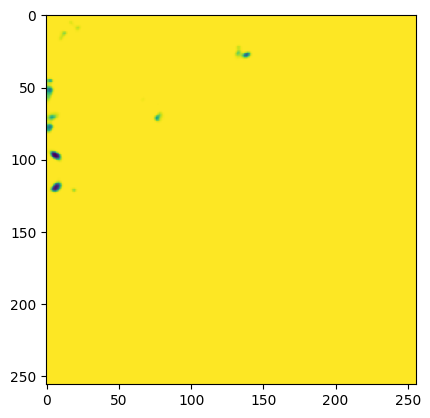

In [19]:
prediction[0,:,:,0].shape , np.min(prediction[0,:,:,0]), np.max(prediction[0,:,:,0])
plt.imshow(prediction[0,:,:,0])

In [ ]:
mask.shape, np.min(mask), np.max(mask)


(TensorShape([256, 256]), 0.0, 0.003921569)

In [ ]:
im_no = 2
after_img = X_test[im_no]
mask_img = Y_test[im_no]

# 4️⃣ Predict and Visualize Results
pred_mask = model.predict(np.expand_dims(after_img, axis=0))[0]

plt.figure(figsize=(20, 10))
plt.subplot(1, 4, 1)
plt.imshow(after_img[..., :3])  # Show only the first 3 RGB channels
plt.title("Pre-Disaster Image")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(after_img[..., 3:])  # Show only the first 3 RGB channels
plt.title("Post-Disaster Image")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(mask_img)
plt.title("Ground Truth Mask")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(pred_mask )  # Threshold the predicted mask
plt.title("Predicted Mask")
plt.axis('off')

plt.show()





NameError: name 'X_test' is not defined

In [30]:
import plotly.express as px
fig = px.imshow(train_masks[2, :, :, 1], color_continuous_scale='jet')

fig.update_traces(
    hovertemplate='Pixel Value: %{z}<extra></extra>' ) # Customize the hover text



In [33]:
prediction = model.predict(train_masks[2, :, :,:])  # Predict the output for the image

fig = px.imshow(prediction[2,:,:,1], color_continuous_scale='jet')

# Enable hover data to show pixel values
fig.update_traces(
    hovertemplate='Pixel Value: %{z}<extra></extra>' ) # Customize the hover text


: 

Text(0, 0.5, 'Frequency')

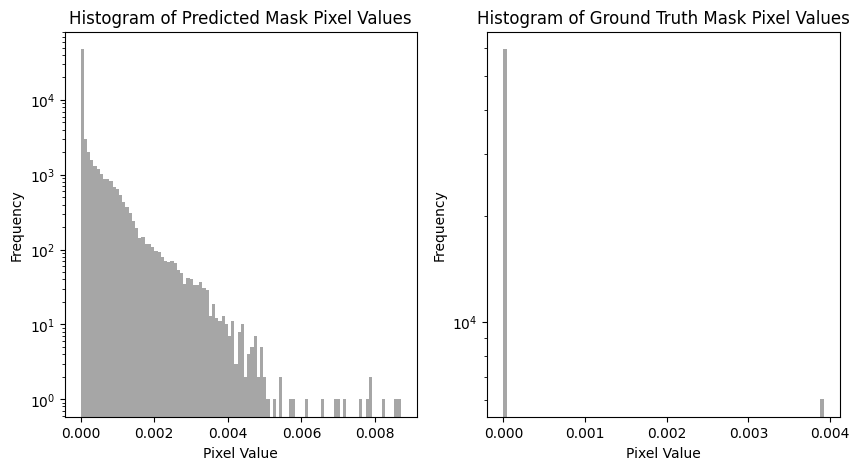

In [58]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(pred_mask.squeeze().flatten(), bins=100, color='gray', alpha=0.7, log=True)
plt.title("Histogram of Predicted Mask Pixel Values")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")

plt.subplot(1,2,2)
plt.hist(mask_img.squeeze().flatten(), bins=100, color='gray', alpha=0.7, log=True)
plt.title("Histogram of Ground Truth Mask Pixel Values")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")


In [37]:
class SiameseUnetSegmentationModel(nn.Module):
    def __init__(
        self,
        encoder: EncoderModule,
        num_classes: int,
        unet_channels: List[int],
        dropout=0.25,
        abn_block: Union[ABN, Callable[[int], nn.Module]] = ABN,
        full_size_mask=True,
        activation=ACT_RELU,
        upsample_block=nn.UpsamplingNearest2d,
    ):
        super().__init__()
        self.encoder = encoder

        feature_maps = [2 * fm for fm in encoder.channels]
        
        abn_block = partial(ABN, activation=activation)
        self.decoder = UNetDecoder(
            feature_maps=feature_maps,
            decoder_features=unet_channels,
            unet_block=partial(UnetBlock, abn_block=abn_block),
            upsample_block=upsample_block,
        )

        self.mask = nn.Sequential(
            OrderedDict([("drop", nn.Dropout2d(dropout)), ("conv", conv1x1(unet_channels[0], num_classes))])
        )        

    def forward(self, image):
        batch_size = image.size(0)
        # Split input image batch into pre- and post- batches
        pre, post = image[:, 0:3, ...], image[:, 3:6, ...] # [B,3,H,W], [B,3,H,W]
        
        # Concatenate them along batch dimension since it's faster than calling self.encoder(pre), self.encoder(post)
        x = torch.cat([pre, post], dim=0) # [2 * B, 3, H, W]
        
        # Encoder
        features = self.encoder(x) # List[Tensor] of strides 4,8,16,32
        
        pre_features = [f[0: batch_size] for f in features]
        post_features = [f[batch_size: batch_size * 2] for f in features]
        features = [torch.cat([pre, post], dim=1) for pre, post in zip(pre_features, post_features)]
        
        # Decoder part
        features = self.decoder(features)
        
        # Decode mask
        mask = self.mask(features[0])
        mask = F.interpolate(mask, size=image.size()[2:], mode="bilinear", align_corners=False)

        output = {OUTPUT_DAMAGE_MASK_KEY: mask}
        return output

def siamese_b4_unet64(input_channels=3, num_classes=5, dropout=0.2, pretrained=True):
    encoder = B4Encoder(pretrained=pretrained)
    if input_channels != 3:
        encoder.change_input_channels(input_channels)

    return SiameseUnetSegmentationModel(
        encoder, num_classes=num_classes, unet_channels=[64, 128, 256], activation=ACT_SWISH, dropout=dropout
    )



NameError: name 'nn' is not defined